### Part 1: Create the Search, Report, and Validation Agents

#### Step 1: Load packages

In [5]:
import os
import logging
import json
from semantic_kernel.functions import kernel_function
from dotenv import load_dotenv
from azure.ai.projects import AIProjectClient
from azure.ai.projects.models import ConnectionType
from azure.identity import DefaultAzureCredential
from azure.ai.projects.models import AzureAISearchTool
from semantic_kernel.agents import ChatCompletionAgent
from semantic_kernel.connectors.ai.open_ai import AzureChatCompletion
from semantic_kernel.contents.chat_message_content import ChatMessageContent
from semantic_kernel.contents.chat_history import ChatHistory
from semantic_kernel.connectors.ai.function_choice_behavior import FunctionChoiceBehavior
from semantic_kernel.connectors.ai.function_choice_behavior import FunctionChoiceBehavior
from semantic_kernel.contents.utils.author_role import AuthorRole
from semantic_kernel.kernel import Kernel

load_dotenv()

True

#### Step 2: Create the Search Agent
To create the Search Agent, we can reuse the code from Lab 3 with a few key changes to integrate with Semantic Kernel. That is, we'll create a "plugin" for our Search Agent. A plugin in Semantic Kernel is a collection of actions that an Agent is able to take. In our case, the action that we want to take is searching an Azure AI Search index for our health plan documents. So we'll create a Search Agent plugin that has a search action. In code, this translates to creating a `SearchAgent` class and a kernel function for searching the Azure AI Search index. A "kernel" is the central component of Semantic Kernel and manages all the plugins and actions that are needed in the multi-agent system.

In [6]:
class SearchAgent:
    """
    A class to represent the Search Agent.
    """
    @kernel_function(description='An agent that searches health plan documents.')
    def search_plan_docs(self, plan_name:str) -> str:
        """
        Creates an Azure AI Agent that searches an Azure AI Search index for information about a health plan.

        Parameters:
        plan_name (str): The name of the health plan to search for.

        Returns:
        last_msg (json): The last message from the agent, which contains the information about the health plan.

        """
        print("Calling SearchAgent...")

        # Connecting to our Azure AI Foundry project, which will allow us to use the deployed gpt-4o model for our agent
        project_client = AIProjectClient.from_connection_string(
            credential=DefaultAzureCredential(),
            conn_str=os.environ["AIPROJECT_CONNECTION_STRING"],
            )
        
        # Iterate through the connections in your project and get the connection ID of the Aazure AI Search connection.
        conn_list = project_client.connections.list()
        conn_id = ""
        for conn in conn_list:
            if conn.connection_type == "CognitiveSearch":
                conn_id = conn.id
        # Connect to your Azure AI Search index
        ai_search = AzureAISearchTool(index_connection_id=conn_id, index_name="health-plan")

        # Create an agent that will be used to search for health plan information
        search_agent = project_client.agents.create_agent(
            model="gpt-4o",
            name="search-agent",
            instructions="You are a helpful agent that is an expert at searching health plan documents.", # System prompt for the agent
            tools=ai_search.definitions,
            tool_resources=ai_search.resources,
        ) 

        # Create a thread which is a conversation session between an agent and a user. 
        thread = project_client.agents.create_thread()

        # Create a message in the thread with the user asking for information about a specific health plan
        message = project_client.agents.create_message(
            thread_id=thread.id,
            role="user",
            content=f"Tell me about the {plan_name} plan.", # The user's message
        )

        # Run the agent to process tne message in the thread
        run = project_client.agents.create_and_process_run(thread_id=thread.id, assistant_id=search_agent.id)

        # Check if the run was successful
        if run.status == "failed":
            print(f"Run failed: {run.last_error}")

        # Delete the agent when it's done running
        project_client.agents.delete_agent(search_agent.id)

        # Fetch all the messages from the thread
        messages = project_client.agents.list_messages(thread_id=thread.id)

        # Get the last message, which is the agent's resposne to the user's question
        last_msg = messages.get_last_text_message_by_role("assistant")

        print("SearchAgent completed successfully.")

        return last_msg


#### Step 3: Create the Report Agent

In [7]:
class ReportAgent:
    """
    A class to represent the Report Agent.
    """
    @kernel_function(description='An agent that writes detailed reports about health plans.')
    def write_report(self, plan_name:str, plan_info:str) -> str:
        """
        Creates an Azure AI Agent that writes a detailed report about a health plan.

        Parameters:
        plan_name (str): The name of the health plan to search for.
        plan_info (str): The information about the speciifc health plan to include in the report.

        Returns:
        last_msg (json): The last message from the agent, which contains the detailed report about the health plan.

        """
        print("Calling ReportAgent...")

        # Connecting to our Azure AI Foundry project, which will allow us to use the deployed gpt-4o model for our agent
        project_client = AIProjectClient.from_connection_string(
            credential=DefaultAzureCredential(),
            conn_str=os.environ["AIPROJECT_CONNECTION_STRING"],
            )

        # Create an agent that will be used to write a detailed report about a health plan
        report_agent = project_client.agents.create_agent(
            model="gpt-4o",
            name="report-agent",
            instructions="You are a helpful agent that is an expert at writing detailed reports about health plans.", # System prompt for the agent
        ) 

        # Create a thread which is a conversation session between an agent and a user. 
        thread = project_client.agents.create_thread()

        # Create a message in the thread with the user asking for information about a specific health plan
        message = project_client.agents.create_message(
            thread_id=thread.id,
            role="user",
            content=f"Write a detailed report about the {plan_name} plan. Make sure to include information about coverage exclusions. Here is the relevant information for the plan: {plan_info}.", # The user's message
        )
        # Run the agent to process tne message in the thread
        run = project_client.agents.create_and_process_run(thread_id=thread.id, assistant_id=report_agent.id)

        # Check if the run was successful
        if run.status == "failed":
            print(f"Run failed: {run.last_error}")

        # Delete the agent when it's done running
        project_client.agents.delete_agent(report_agent.id)

        # Fetch all the messages from the thread
        messages = project_client.agents.list_messages(thread_id=thread.id)

        # Get the last message, which is the agent's resposne to the user's question
        last_msg = messages.get_last_text_message_by_role("assistant")

        print("ReportAgent completed successfully.")

        return last_msg


#### Step 4: Create the Validation Agent

In [8]:
class ValidationAgent:
    """
    A class to represent the Validation Agent.
    """
    @kernel_function(description='An agent that runs validation checks to ensure the generated report meets requirements.')
    def validate_report(self, report:str) -> str:
        """
        Creates an Azure AI Agent that validates that the report generated by the Report Agent meets requirements.
        Coverage Exlusion Requirement: The report must include information about coverage exclusions.

        Parameters:
        report (str): The report generated by the Report Agent.

        Returns:
        last_msg (json): The last message from the agent, which contains the validation results.

        """
        print("Calling ValidationAgent...")

        # Connecting to our Azure AI Foundry project, which will allow us to use the deployed gpt-4o model for our agent
        project_client = AIProjectClient.from_connection_string(
            credential=DefaultAzureCredential(),
            conn_str=os.environ["AIPROJECT_CONNECTION_STRING"],
            )

        # Create an agent that will be used to validate that the generated report meets requirements
        validation_agent = project_client.agents.create_agent(
            model="gpt-4o",
            name="validation-agent",
            instructions="You are a helpful agent that is an expert at validating that reports meet requirements. Return 'Pass' if the report meets requirement or 'Fail' if it does not meet requirements. You must only return 'Pass' or 'Fail'.", # System prompt for the agent
        ) 

        # Create a thread which is a conversation session between an agent and a user. 
        thread = project_client.agents.create_thread()

        # Create a message in the thread with the user asking for the agent to validate that the generated report includes information about coverage exclusions
        message = project_client.agents.create_message(
            thread_id=thread.id,
            role="user",
            content=f"Validate that the generated report includes information about coverage exclusions. Here is the generated report: {report}", # The user's message
        )
        # Run the agent to process tne message in the thread
        run = project_client.agents.create_and_process_run(thread_id=thread.id, assistant_id=validation_agent.id)

        # Check if the run was successful
        if run.status == "failed":
            print(f"Run failed: {run.last_error}")

        # Delete the agent when it's done running
        project_client.agents.delete_agent(validation_agent.id)

        # Fetch all the messages from the thread
        messages = project_client.agents.list_messages(thread_id=thread.id)

        # Get the last message, which is the agent's resposne to the user's question
        last_msg = messages.get_last_text_message_by_role("assistant")

        print("ValidationAgent completed successfully.")

        return last_msg


### Part 2: Create a multi-agent system

Now that we've created our three task agents, the Search, Report, and Validation agents, we can put it all together and create a multi-agent system. We'll use Semantic Kernel to create an Orchestrator Agent that will leverage the three agents to create a report about a health plan. 

When you run the below cell, you will see a chat box pop up at the top of VS Code asking you to input the name of a health plan. If you recall, we uploaded two health plans to the search index. Type one of the following health plans in the box and press enter to begin running the multi-agent system:
* Northwind Health Standard
* Northwind Health Plus

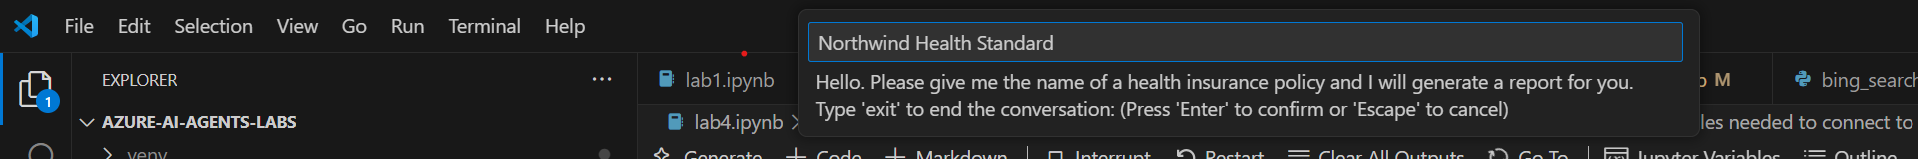

If the multi-agent system runs successfully, you'll see a message saying that your report has been generated and saved to a file. You should also see that a file named after the health plan you specified has been created which contains the report that the multi-agent system has generated. If the multi-agent system was not able to generate a report, you'll see an explanation from the Orchestrator Agent stating why it wasn't able to generate a report. You can type "exit" to end the execution of the program. 

You'll notice that logging is enabled in the below cell. This is done so you can see that the Orchestrator Agent is invoking the Search, Report, and Validation agents to write the report, thus doing its job as an Orchestrator. It will first call the Search Agent to obtain information about the health plan that the user inputted. After retreiving this information, it will call the Report Agent to generate the report. Lastly, it will call the Validation Agent to ensure that the generated report includes information about coverage exlusions.

Notice that all of this orchestration logic is done behind the scenes, enabling seamless development of multi-agent systems.

In [9]:
# The envionrment variables needed to connect to the gpt-4o model in Azure AI Foundry
deployment_name = os.environ["CHAT_MODEL"]
endpoint = os.environ["CHAT_MODEL_ENDPOINT"]
api_key = os.environ["CHAT_MODEL_API_KEY"]

async def main():
    # The Kernel is the main entry point for the Semantic Kernel. It will be used to add services and plugins to the Kernel.
    kernel = Kernel()

    # Add the necessary services and plugins to the Kernel
    # Adding the ReportAgent and SearchAgent plugins will allow the OrchestratorAgent to call the functions in these plugins
    service_id = "orchestrator_agent"
    kernel.add_service(AzureChatCompletion(service_id=service_id, deployment_name=deployment_name, endpoint=endpoint, api_key=api_key))
    kernel.add_plugin(ReportAgent(), plugin_name="ReportAgent")
    kernel.add_plugin(SearchAgent(), plugin_name="SearchAgent")
    kernel.add_plugin(ValidationAgent(), plugin_name="ValidationAgent")

    settings = kernel.get_prompt_execution_settings_from_service_id(service_id=service_id)
    # Configure the function choice behavior to automatically invoke kernel functions
    settings.function_choice_behavior = FunctionChoiceBehavior.Auto()

    # Create the Orchestrator Agent that will call the Search and Report agents to create the report
    agent = ChatCompletionAgent(
        service_id="orchestrator_agent",
        kernel=kernel, # The Kernel that contains the services and plugins
        name="OrchestratorAgent",
        instructions=f"""
            You are an agent designed to create detailed reports about health plans. The user will provide the name of a health plan and you will create a detailed report about that health plan. You will also need to validate that the report meets requirements. Call the appropriate functions to help write the report. 
            Do not write the report on your own. Your role is to be an orchestrator who will call the appropriate plugins and functions provided to you. Each plugin that you have available is an agent that can accomplish a specific task. Here are descriptions of the plugins you have available:
            
            - ReportAgent: An agent that writes detailed reports about health plans.
            - SearchAgent: An agent that searches health plan documents.
            - ValidationAgent: An agent that runs validation checks to ensure the generated report meets requirements. It will return 'Pass' if the report meets requirements or 'Fail' if it does not meet requirements.

            Validating that the report meets requirements is critical. If the report does not meet requirements, you must inform the user that the report could not be generated. Do not output a report that does not meet requirements to the user.
            If the report meets requirements, you can output the report to the user. Format your response as a JSON object with two attributes, report_was_generated and content. Here are descriptions of the two attributes:

            - report_was_generated: A boolean value that indicates whether the report was generated. If the report was generated, set this value to True. If the report was not generated, set this value to False.
            - content: A string that contains the report. If the report was generated, this string should contain the detailed report about the health plan. If the report was not generated, this string should contain a message to the user indicating that the report could not be generated.
             
            Here's an example of a JSON object that you can return to the user:
            {{"report_was_generated": false, "content": "The report for the Northwind Standard health plan could not be generated as it did not meet the required validation standards."}}

            Your response must contain only a single valid JSON object. Do not include any additional text, comments, or blank lines before or after it. Use lowercase booleans (true/false) and double quotes for all keys and string values. The JSON object that you generate will be parsed in Python using the json.loads() method. If your output is not a valid JSON object, it will cause an error in the Python code.
            """,
        execution_settings=settings,
    )

    # Start the conversation with the user
    history = ChatHistory()

    is_complete = False
    while not is_complete:
        # Start the logging
        print("Orchestrator Agent is starting...")

        # The user will provide the name of the health plan
        user_input = input("Hello. Please give me the name of a health insurance policy and I will generate a report for you. Type 'exit' to end the conversation: ")
        if not user_input:
            continue
        
        # The user can type 'exit' to end the conversation
        if user_input.lower() == "exit":
            is_complete = True
            break

        # Add the user's message to the chat history
        history.add_message(ChatMessageContent(role=AuthorRole.USER, content=user_input))

        # Invoke the Orchestrator Agent to generate the report based on the user's input
        async for response in agent.invoke(history=history):
            # Ensure that boolean values are lowercase as it's required JSON formatting
            fixed_content = response.content.replace("False", "false").replace("True", "true")
            response_json = json.loads(fixed_content)
            report_was_generated = response_json['report_was_generated']
            report_content = response_json['content']

            # Save the report to a file if it was generated
            if report_was_generated:
                report_name = f"{user_input} Report.md"
                with open(f"{report_name}", "w") as f:
                    f.write(report_content)
                    print(f"The report for {user_input} has been generated. Please check the {report_name} file for the report.")
            # Print the requirements failed message if the report was not generated
            elif not report_was_generated:
                print(report_content)
            else:
                print("An unexpected response was received. Please try again") # Print an error message if an unexpected response was received




await main()

Orchestrator Agent is starting...
Calling SearchAgent...
SearchAgent completed successfully.
Calling ReportAgent...
ReportAgent completed successfully.
Calling ValidationAgent...
ValidationAgent completed successfully.
The report for Northwind Health Standard has been generated. Please check the Northwind Health Standard Report.md file for the report.
Orchestrator Agent is starting...
Calling SearchAgent...
SearchAgent completed successfully.
Calling ReportAgent...
ReportAgent completed successfully.
Calling ValidationAgent...
ValidationAgent completed successfully.
The report for the Northwind Health Plus1 health plan could not be generated as it did not meet the required validation standards.
Orchestrator Agent is starting...
